### 1.1 Overview of Text-to-Image Generation

Text-to-image generation is a fascinating application of generative AI that allows us to create visual content directly from natural language descriptions. This capability has profound implications for creative fields, content creation, and human-computer interaction.

In this notebook, we'll explore how diffusion models have revolutionized text-to-image generation, producing highly realistic and creative images that closely match textual prompts. We'll cover the theoretical foundations of diffusion models, their architecture specifically for text conditioning, and implement a simplified version to understand the core concepts.

By the end of this notebook, you'll understand:
- How diffusion models work, from mathematical foundations to implementation
- How text conditioning enables precise control over image generation
- Key techniques used in state-of-the-art text-to-image systems
- Practical considerations for training and deploying such models

### 1.2 Historical Context and Evolution

Text-to-image generation has evolved considerably over the years:

1. **Early Approaches (2016-2018)**: Initial systems like GAN-CLS and AttnGAN used generative adversarial networks (GANs) for text-to-image synthesis but struggled with complex scenes and often produced blurry or unrealistic images.

2. **Intermediate Developments (2019-2021)**: Models like DALL-E (based on autoregressive transformers) and CLIP (Contrastive Language-Image Pre-training) established stronger connections between language and visual domains.

3. **Diffusion Revolution (2022-Present)**: Diffusion models like DALL-E 2, Imagen, Stable Diffusion, and Midjourney dramatically improved image quality, compositional understanding, and photorealism.

The current state-of-the-art approaches predominantly use diffusion models, which have demonstrated superior capabilities in terms of image quality, prompt adherence, and creative flexibility.

### 2.1 Diffusion Models: Core Concepts

Diffusion models belong to the family of generative models but take a unique approach to generation. They work by learning to reverse a gradual noising process:

1. **Forward Diffusion Process**: Systematically and gradually adds Gaussian noise to data over multiple timesteps until the data becomes pure noise.

2. **Reverse Diffusion Process**: The model learns to reverse this process by predicting and removing noise step by step, starting from random noise and progressively denoising until a clean image forms.

This approach differs fundamentally from GANs (which use adversarial training) and VAEs (which use direct encoding and decoding). Diffusion models have shown exceptional sample quality and training stability compared to other generative approaches.

The following diagram illustrates the forward and reverse diffusion processes:

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from tqdm.notebook import tqdm
import os


In [16]:
def create_synthetic_image_simple(size=128):
    """Create a simplified synthetic image without ConvexHull"""
    img = np.zeros((size, size, 3))

    # Add a red circle
    center = (size // 3, size // 3)
    radius = size // 6
    y, x = np.ogrid[:size, :size]
    mask = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= radius ** 2
    img[mask] = [1, 0, 0]  # Red

    # Add a blue square
    start = 2 * size // 3 - size // 8
    end = 2 * size // 3 + size // 8
    img[start:end, start:end] = [0, 0, 1]  # Blue

    # Add a simple triangle (without ConvexHull)
    p1 = (size//2, size//6)
    p2 = (size//3, size//2)
    p3 = (2*size//3, size//2)

    # Simple triangle filling
    for i in range(size):
        for j in range(size):
            # Basic triangle inside test - this is simplified
            if is_point_in_triangle((i, j), p1, p2, p3):
                img[j, i] = [0, 1, 0]  # Green

    # Convert to tensor format
    img_tensor = torch.from_numpy(img.transpose(2, 0, 1)).float().unsqueeze(0)

    # Save without displaying
    plt.imsave("synthetic_image.jpg", img)

    return img_tensor, "synthetic_image.jpg"

def is_point_in_triangle(p, p1, p2, p3):
    """Simple function to check if a point is inside a triangle"""
    def sign(p1, p2, p3):
        return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])

    d1 = sign(p, p1, p2)
    d2 = sign(p, p2, p3)
    d3 = sign(p, p3, p1)

    has_neg = (d1 < 0) or (d2 < 0) or (d3 < 0)
    has_pos = (d1 > 0) or (d2 > 0) or (d3 > 0)

    return not (has_neg and has_pos)

In [17]:
def visualize_diffusion_process_simple(image_tensor, num_steps=5):
    """Simplified version with fewer steps"""
    # Create figure (smaller size)
    fig, axes = plt.subplots(2, num_steps, figsize=(10, 4))

    # Set title
    fig.suptitle('Diffusion Process Visualization', fontsize=12)

    # Noise schedule
    betas = np.linspace(0.0001, 0.02, num_steps)

    # Forward process (top row)
    noisy_image = image_tensor.clone()
    for i in range(num_steps):
        if i > 0:
            # Add noise according to schedule
            noise = torch.randn_like(noisy_image) * np.sqrt(betas[i])
            noisy_image = np.sqrt(1 - betas[i]) * noisy_image + noise

        # Convert tensor to numpy and display
        img_np = noisy_image.squeeze().permute(1, 2, 0).clip(0, 1).numpy()
        axes[0, i].imshow(img_np)
        axes[0, i].set_title(f"Step {i}")
        axes[0, i].axis('off')

    # Reverse process (bottom row) - simplified
    noise_img = torch.randn_like(image_tensor)
    for i in range(num_steps):
        alpha = i / (num_steps - 1)
        reversed_img = (1 - alpha) * noise_img + alpha * image_tensor

        img_np = reversed_img.squeeze().permute(1, 2, 0).clip(0, 1).numpy()
        axes[1, num_steps - i - 1].imshow(img_np)
        axes[1, num_steps - i - 1].set_title(f"Step {num_steps - i - 1}")
        axes[1, num_steps - i - 1].axis('off')

    plt.tight_layout()
    return fig

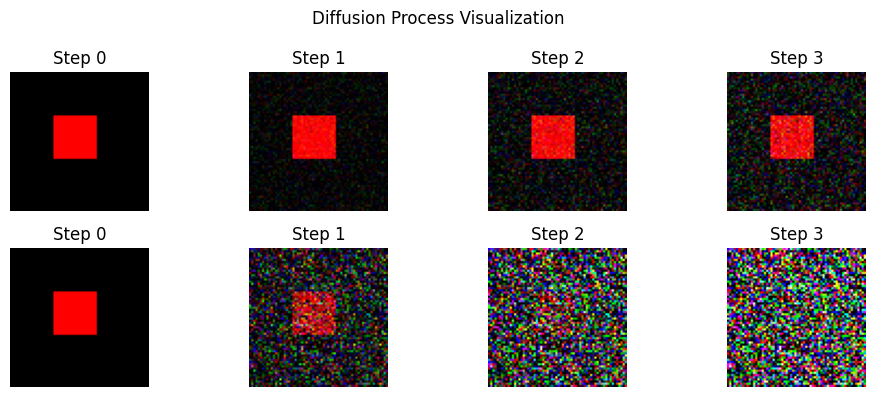

In [18]:
# Create a very simple image (just a small colored square)
def create_minimal_test_image(size=64):
    img = np.zeros((size, size, 3))
    img[20:40, 20:40, 0] = 1.0  # Red square
    img_tensor = torch.from_numpy(img.transpose(2, 0, 1)).float().unsqueeze(0)
    return img_tensor

# Test with minimal image
test_tensor = create_minimal_test_image()
test_fig = visualize_diffusion_process_simple(test_tensor, num_steps=4)
plt.show()

### 2.2 Mathematical Foundation

The diffusion process is founded on principles from non-equilibrium thermodynamics and can be mathematically formulated as follows:

**Forward Diffusion Process:**
This process gradually adds noise to an image $x_0$ through T steps, producing a sequence $x_1, x_2, ..., x_T$. Each step follows:

$$q(x_t | x_{t-1}) = \mathcal{N}(x_t; \sqrt{1 - \beta_t} x_{t-1}, \beta_t \mathbf{I})$$

Where $\beta_t$ is a noise schedule that typically increases over time.

An important property is that we can sample $x_t$ directly from $x_0$ using:

$$q(x_t | x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t} x_0, (1 - \bar{\alpha}_t) \mathbf{I})$$

Where $\alpha_t = 1 - \beta_t$ and $\bar{\alpha}_t = \prod_{i=1}^t \alpha_i$.

**Reverse Diffusion Process:**
The model learns to reverse this process by approximating:

$$p_\theta(x_{t-1} | x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t, t), \Sigma_\theta(x_t, t))$$

Where $\mu_\theta$ is predicted by our model.

**Training Objective:**
The model is trained to predict the noise that was added at each step, using a simplified objective:

$$L_{simple} = \mathbb{E}_{t, x_0, \epsilon} \left[ \|\epsilon - \epsilon_\theta(x_t, t)\|^2 \right]$$

Where $\epsilon$ is the noise added and $\epsilon_\theta$ is the model's prediction.

### 2.3 Architectural Components

Modern diffusion models for image generation typically use U-Net architectures with several key components:

1. **Encoder-Decoder Structure**: A U-Net with skip connections to capture both local details and global context.

2. **Time Conditioning**: Information about the current noise level (timestep) is injected into the model, often using sinusoidal position embeddings.

3. **Attention Mechanisms**: Self-attention layers help the model capture long-range dependencies in the image.

4. **Residual Blocks**: These facilitate gradient flow during training of deep networks.

Here's a high-level diagram of a typical diffusion model architecture:

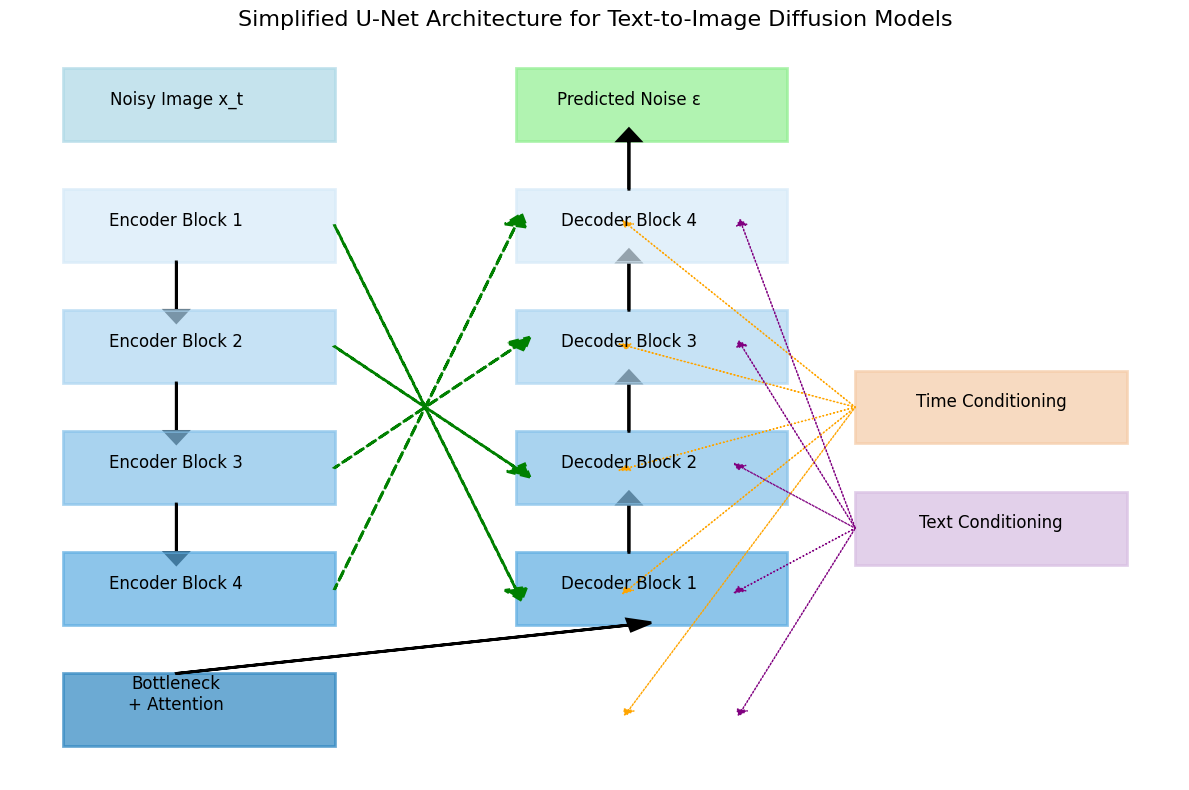

In [28]:
# Let's visualize a simplified U-Net architecture for diffusion models
def plot_unet_architecture():
    """Create a diagram of a simplified U-Net architecture for diffusion models"""
    fig, ax = plt.subplots(figsize=(12, 8))

    # Hide axes
    ax.axis('off')

    # Define box coordinates and sizes
    box_height = 0.6
    box_width = 1.2

    # Input
    ax.add_patch(plt.Rectangle((0, 5), box_width, box_height, fill=True,
                               color='lightblue', alpha=0.7, linewidth=2))
    ax.text(0.5, 5.3, "Noisy Image x_t", ha='center', fontsize=12)

    # Encoder blocks
    encoder_colors = ['#D6EAF8', '#AED6F1', '#85C1E9', '#5DADE2']

    for i, color in enumerate(encoder_colors):
        y_pos = 4 - i
        ax.add_patch(plt.Rectangle((0, y_pos), box_width, box_height, fill=True,
                                  color=color, alpha=0.7, linewidth=2))
        ax.text(0.5, y_pos + 0.3, f"Encoder Block {i+1}", ha='center', fontsize=12)

        # Add arrow down
        if i < len(encoder_colors) - 1:
            ax.arrow(0.5, y_pos, 0, -0.4, head_width=0.1, head_length=0.1,
                     fc='black', ec='black', linewidth=2)

    # Bottleneck
    ax.add_patch(plt.Rectangle((0, 0), box_width, box_height, fill=True,
                              color='#2E86C1', alpha=0.7, linewidth=2))
    ax.text(0.5, 0.3, "Bottleneck\n+ Attention", ha='center', fontsize=12)

    # Decoder blocks
    decoder_colors = ['#5DADE2', '#85C1E9', '#AED6F1', '#D6EAF8']

    for i, color in enumerate(decoder_colors):
        y_pos = 1 + i
        x_pos = 2  # Shifted to the right

        ax.add_patch(plt.Rectangle((x_pos, y_pos), box_width, box_height, fill=True,
                                  color=color, alpha=0.7, linewidth=2))
        ax.text(x_pos + 0.5, y_pos + 0.3, f"Decoder Block {i+1}", ha='center', fontsize=12)

        # Add arrow up
        if i < len(decoder_colors) - 1:
            ax.arrow(x_pos + 0.5, y_pos + box_height, 0, 0.4, head_width=0.1, head_length=0.1,
                     fc='black', ec='black', linewidth=2)

        # Add skip connection
        skip_y = 4 - i
        ax.arrow(box_width, skip_y + 0.3, 2 - box_width, y_pos + 0.3 - (skip_y + 0.3),
                 head_width=0.1, head_length=0.1, fc='green', ec='green',
                 linewidth=2, linestyle='dashed')

    # Output
    ax.add_patch(plt.Rectangle((2, 5), box_width, box_height, fill=True,
                              color='lightgreen', alpha=0.7, linewidth=2))
    ax.text(2.5, 5.3, "Predicted Noise ε", ha='center', fontsize=12)

    # Connect bottleneck to first decoder
    ax.arrow(0.5, box_height, 2, 1 - box_height, head_width=0.1, head_length=0.1,
             fc='black', ec='black', linewidth=2)

    # Connect last decoder to output
    ax.arrow(2.5, 4 + box_height, 0, 5 - (4 + box_height), head_width=0.1, head_length=0.1,
             fc='black', ec='black', linewidth=2)

    # Add time conditioning
    ax.add_patch(plt.Rectangle((3.5, 2.5), box_width, box_height, fill=True,
                              color='#F5CBA7', alpha=0.7, linewidth=2))
    ax.text(4.1, 2.8, "Time Conditioning", ha='center', fontsize=12)

    # Add arrows for time conditioning to various blocks
    for y_pos in [0.3, 1.3, 2.3, 3.3, 4.3]:
        ax.arrow(3.5, 2.8, -1.0, y_pos - 2.8, head_width=0.05, head_length=0.05,
                 fc='orange', ec='orange', linewidth=1, linestyle='dotted')

    # Add text conditioning
    text_box_x = 3.5
    text_box_y = 1.5

    ax.add_patch(plt.Rectangle((text_box_x, text_box_y), box_width, box_height, fill=True,
                              color='#D7BDE2', alpha=0.7, linewidth=2))
    ax.text(text_box_x + 0.6, text_box_y + 0.3, "Text Conditioning", ha='center', fontsize=12)

    # Add arrows for text conditioning to various blocks
    for y_pos in [0.3, 1.3, 2.3, 3.3, 4.3]:
        ax.arrow(text_box_x, text_box_y + 0.3, -0.5, y_pos - (text_box_y + 0.3),
                 head_width=0.05, head_length=0.05, fc='purple', ec='purple',
                 linewidth=1, linestyle='dotted')

    # Title
    plt.title("Simplified U-Net Architecture for Text-to-Image Diffusion Models", fontsize=16)

    plt.tight_layout()
    return fig

# Create the architecture diagram
unet_fig = plot_unet_architecture()
# plt.close(unet_fig)  # Comment out or remove this line
plt.show()  # Add this line to display the figure

### 3.1 Text Encoding and Conditioning

To generate images from text, diffusion models need a way to understand and incorporate textual information. This is accomplished through text conditioning mechanisms:

1. **Text Encoder**: A pre-trained language model (often CLIP, T5, or BERT) encodes text prompts into rich embeddings that capture semantic meaning.

2. **Cross-Attention Mechanism**: The text embeddings are injected into the diffusion model using cross-attention layers, which allow the model to "attend" to relevant parts of the text while generating the image.

3. **Conditioning Scale**: A parameter that controls how closely the generation follows the text prompt.

The text conditioning process can be represented mathematically as:

$$\epsilon_\theta(x_t, t, c_{text})$$

Where $c_{text}$ is the text conditioning vector derived from the prompt.

Let's implement a simplified text encoder and cross-attention mechanism:

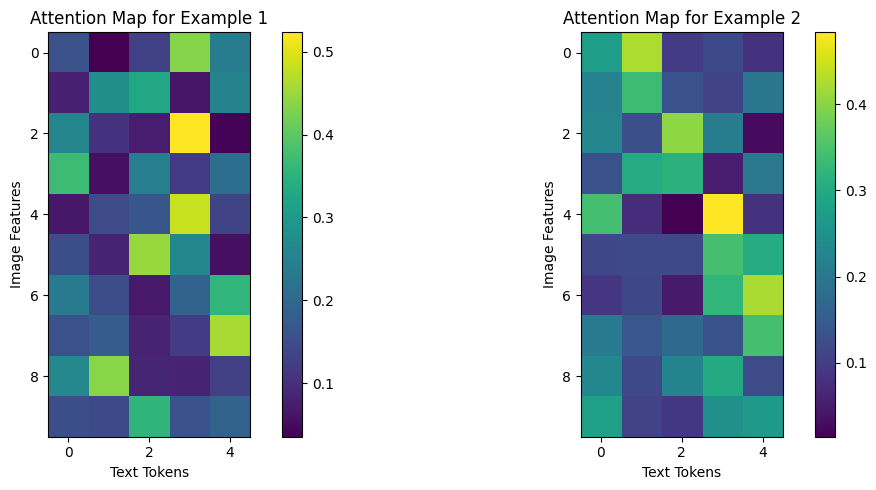

In [29]:
class TextEncoder(nn.Module):
    """
    Simplified text encoder that mimics the function of models like CLIP
    """
    def __init__(self, vocab_size=10000, embedding_dim=512, hidden_dim=2048, output_dim=768):
        super(TextEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=8,
                                       dim_feedforward=hidden_dim, batch_first=True),
            num_layers=6
        )
        self.projection = nn.Linear(embedding_dim, output_dim)

    def forward(self, input_ids):
        """
        Args:
            input_ids: Long tensor of shape [batch_size, seq_len]
        Returns:
            Text embeddings of shape [batch_size, seq_len, output_dim]
        """
        embeddings = self.embedding(input_ids)
        encoded = self.transformer(embeddings)
        projected = self.projection(encoded)
        return projected


class CrossAttention(nn.Module):
    """
    Cross-attention module to incorporate text embeddings into the diffusion process
    """
    def __init__(self, query_dim, context_dim, heads=8, dim_head=64):
        super(CrossAttention, self).__init__()
        self.scale = dim_head ** -0.5
        inner_dim = dim_head * heads

        self.heads = heads
        self.dim_head = dim_head

        # Query projections for image features
        self.to_q = nn.Linear(query_dim, inner_dim, bias=False)

        # Key and value projections for text features
        self.to_k = nn.Linear(context_dim, inner_dim, bias=False)
        self.to_v = nn.Linear(context_dim, inner_dim, bias=False)

        self.to_out = nn.Linear(inner_dim, query_dim)

    def forward(self, x, context):
        """
        Args:
            x: Image features [batch, seq_len_img, query_dim]
            context: Text embeddings [batch, seq_len_text, context_dim]
        Returns:
            Attended features [batch, seq_len_img, query_dim]
        """
        # Get dimensions
        batch_size, seq_len_q, _ = x.shape
        _, seq_len_k, _ = context.shape

        # Project queries, keys, values
        q = self.to_q(x)
        k = self.to_k(context)
        v = self.to_v(context)

        # Reshape for multi-head attention
        q = q.view(batch_size, seq_len_q, self.heads, self.dim_head).transpose(1, 2)
        k = k.view(batch_size, seq_len_k, self.heads, self.dim_head).transpose(1, 2)
        v = v.view(batch_size, seq_len_k, self.heads, self.dim_head).transpose(1, 2)

        # Compute attention scores
        attention = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attention = F.softmax(attention, dim=-1)

        # Apply attention to values
        out = torch.matmul(attention, v)

        # Reshape back
        out = out.transpose(1, 2).reshape(batch_size, seq_len_q, -1)

        # Project to output dimension
        return self.to_out(out)


# Demonstration of text conditioning
def demonstrate_text_conditioning():
    """Visualize how text conditioning influences the diffusion process"""
    # Create a simplified example
    batch_size = 2
    seq_len = 10
    img_feature_dim = 64
    text_feature_dim = 768

    # Simulate image features (from diffusion model)
    img_features = torch.randn(batch_size, seq_len, img_feature_dim)

    # Simulate two different text prompts
    text_embeddings = torch.randn(batch_size, 5, text_feature_dim)

    # Create cross-attention module
    cross_attn = CrossAttention(img_feature_dim, text_feature_dim)

    # Apply cross-attention
    conditioned_features = cross_attn(img_features, text_embeddings)

    # Visualize attention maps (simplified)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # For each example in the batch
    for i in range(batch_size):
        # Compute simplified attention map for visualization
        q = cross_attn.to_q(img_features[i:i+1])
        k = cross_attn.to_k(text_embeddings[i:i+1])

        # Reshape for visualization
        q = q.view(seq_len, -1)
        k = k.view(5, -1)

        # Compute attention (simplified)
        attn_map = torch.matmul(q, k.transpose(0, 1)) / (img_feature_dim ** 0.5)
        attn_map = F.softmax(attn_map, dim=1).detach().numpy()

        # Plot attention map
        im = axes[i].imshow(attn_map, cmap='viridis')
        axes[i].set_title(f"Attention Map for Example {i+1}")
        axes[i].set_xlabel("Text Tokens")
        axes[i].set_ylabel("Image Features")

        # Add colorbar
        plt.colorbar(im, ax=axes[i])

    plt.tight_layout()
    return fig

# Create the text conditioning visualization
text_conditioning_fig = demonstrate_text_conditioning()
# plt.close(text_conditioning_fig)
plt.show()

### 3.2 Multi-Modal Conditioning

Modern text-to-image diffusion models often employ multiple conditioning signals beyond just text:

1. **Text Prompts**: The primary conditioning signal, providing semantic guidance.

2. **Class Labels**: Optional categorical information that can guide generation.

3. **Layout Conditioning**: Spatial information about where objects should appear.

4. **Image Conditioning**: Reference images that influence style or content.

5. **Control Maps**: Specialized signals like depth maps, edge maps, or pose skeletons.

The integration of these signals allows for more precise control over the generation process. For instance, models like ControlNet and T2I-Adapter have extended diffusion models to incorporate additional conditioning signals.

Here's how multi-modal conditioning might be incorporated:

$$\epsilon_\theta(x_t, t, c_{text}, c_{layout}, c_{control}, ...)$$

Where each $c$ represents a different conditioning signal.

### 3.3 Classifier-Free Guidance

A key technique for improving text-to-image alignment is classifier-free guidance (CFG). This approach enhances how closely the generated image follows the text prompt by:

1. Training the model to sometimes generate unconditionally (without text)
2. During inference, computing both conditional and unconditional predictions
3. Extrapolating beyond the conditional prediction to strengthen its influence

Mathematically, it's formulated as:

$$\hat{\epsilon}_\theta(x_t, t, c) = \epsilon_\theta(x_t, t) + w \cdot (\epsilon_\theta(x_t, t, c) - \epsilon_\theta(x_t, t))$$

Where:
- $\epsilon_\theta(x_t, t)$ is the unconditional prediction
- $\epsilon_\theta(x_t, t, c)$ is the conditional prediction
- $w$ is the guidance scale (typically between 5-15)

Higher guidance scales produce images that more closely follow the prompt but may sacrifice some diversity and image quality when set too high.

Let's implement a simple example of classifier-free guidance:

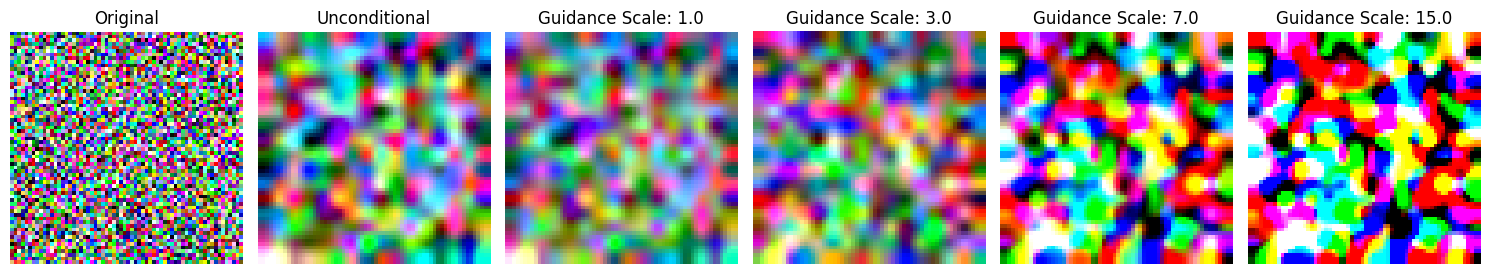

In [30]:
def classifier_free_guidance_example(guidance_scales=[1.0, 3.0, 7.0, 15.0]):
    """
    Demonstrate the effect of different classifier-free guidance scales

    Args:
        guidance_scales: List of guidance scale values to visualize
    """
    # For illustration, we'll create synthetic predictions

    # Create a simplified latent representation
    image_size = 64
    latent_size = 16
    channels = 3

    # Convert to spatial representation for visualization
    def latent_to_image(latent):
        # Upsample to image space using simple interpolation for demonstration
        return F.interpolate(latent, size=image_size, mode='bilinear')

    # Create a "base" noise prediction - unconditional
    unconditional_pred = torch.randn(1, channels, latent_size, latent_size)

    # Create a conditional prediction (different direction in latent space)
    # In reality, these would come from the model predicting noise
    conditional_pred = torch.randn(1, channels, latent_size, latent_size)
    conditional_pred = 0.7 * unconditional_pred + 0.3 * conditional_pred  # Some correlation with unconditional

    # Apply different guidance scales
    fig, axes = plt.subplots(1, len(guidance_scales) + 2, figsize=(15, 5))

    # Plot the "ground truth" first
    image = torch.randn(1, channels, image_size, image_size)  # Random image for reference
    img_np = image.squeeze().permute(1, 2, 0).clip(-1, 1)
    img_np = (img_np + 1) / 2  # Scale from [-1,1] to [0,1]
    axes[0].imshow(img_np)
    axes[0].set_title("Original")
    axes[0].axis('off')

    # Plot unconditional
    uncond_image = latent_to_image(unconditional_pred)
    img_np = uncond_image.squeeze().permute(1, 2, 0).clip(-1, 1)
    img_np = (img_np + 1) / 2
    axes[1].imshow(img_np)
    axes[1].set_title("Unconditional")
    axes[1].axis('off')

    # Plot different guidance scales
    for i, scale in enumerate(guidance_scales):
        # Apply classifier-free guidance formula
        guided_pred = unconditional_pred + scale * (conditional_pred - unconditional_pred)

        # Convert to image for visualization
        guided_image = latent_to_image(guided_pred)

        # Convert to numpy for plotting
        img_np = guided_image.squeeze().permute(1, 2, 0).clip(-1, 1)
        img_np = (img_np + 1) / 2  # Scale from [-1,1] to [0,1]

        # Plot
        axes[i+2].imshow(img_np)
        axes[i+2].set_title(f"Guidance Scale: {scale}")
        axes[i+2].axis('off')

    plt.tight_layout()
    return fig

# Create the classifier-free guidance visualization
cfg_fig = classifier_free_guidance_example()

### 4.1 Model Architecture

Now, let's implement a simplified text-to-image diffusion model architecture that incorporates the concepts we've discussed. This implementation is educational and demonstrates the key components, though a production model would be significantly more complex.

Our simplified architecture includes:
- A U-Net backbone with time conditioning
- Text encoding and cross-attention mechanisms
- Classifier-free guidance capabilities

We'll build this in a modular fashion:

In [31]:
# Time embedding module
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.proj = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.SiLU(),
            nn.Linear(dim * 4, dim * 4),
        )

    def forward(self, timesteps):
        """
        Create sinusoidal time embeddings similar to positional encoding

        Args:
            timesteps: [batch_size] tensor of timesteps
        Returns:
            Time embeddings [batch_size, dim * 4]
        """
        half_dim = self.dim // 2
        emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=timesteps.device) * -emb)
        emb = timesteps.unsqueeze(1) * emb.unsqueeze(0)
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)

        # Map to higher dimension
        return self.proj(emb)


# Residual block with time conditioning
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_dim):
        super().__init__()
        self.time_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_dim, out_channels)
        )

        self.block1 = nn.Sequential(
            nn.GroupNorm(32, in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, 3, padding=1)
        )

        self.block2 = nn.Sequential(
            nn.GroupNorm(32, out_channels),
            nn.SiLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1)
        )

        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, 1)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x, time_emb):
        """
        Args:
            x: Image features [batch, in_channels, height, width]
            time_emb: Time embeddings [batch, time_dim]
        """
        h = self.block1(x)
        time_emb = self.time_mlp(time_emb).unsqueeze(-1).unsqueeze(-1)
        h = h + time_emb
        h = self.block2(h)
        return h + self.shortcut(x)


# Attention block for adding cross-attention with text
class AttentionBlock(nn.Module):
    def __init__(self, channels, text_dim=768):
        super().__init__()
        self.channels = channels

        # Self-attention for image features
        self.norm1 = nn.GroupNorm(32, channels)
        self.self_attn = nn.MultiheadAttention(channels, 8, batch_first=True)

        # Cross-attention for text conditioning
        self.norm2 = nn.GroupNorm(32, channels)
        self.cross_attn = CrossAttention(channels, text_dim)

        # Feed-forward network
        self.norm3 = nn.GroupNorm(32, channels)
        self.ff = nn.Sequential(
            nn.Conv2d(channels, channels * 4, 1),
            nn.SiLU(),
            nn.Conv2d(channels * 4, channels, 1)
        )

    def forward(self, x, text_embeddings=None):
        """
        Args:
            x: Image features [batch, channels, height, width]
            text_embeddings: Text features [batch, seq_len, text_dim]
        """
        b, c, h, w = x.shape

        # Reshape spatial dims to sequence
        x_seq = x.view(b, c, -1).permute(0, 2, 1)  # [b, h*w, c]

        # Self-attention
        norm_x = self.norm1(x).view(b, c, -1).permute(0, 2, 1)
        self_attn_out, _ = self.self_attn(norm_x, norm_x, norm_x)
        x_seq = x_seq + self_attn_out

        # Cross-attention with text (if provided)
        if text_embeddings is not None:
            norm_x = self.norm2(x_seq.permute(0, 2, 1).view(b, c, h, w)).view(b, c, -1).permute(0, 2, 1)
            x_seq = x_seq + self.cross_attn(norm_x, text_embeddings)

        # Feed-forward network
        x = x_seq.permute(0, 2, 1).view(b, c, h, w)
        x = x + self.ff(self.norm3(x))

        return x


# Downsampling and upsampling blocks
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_dim, add_attention=False, text_dim=768):
        super().__init__()
        self.res_block = ResBlock(in_channels, out_channels, time_dim)
        self.add_attention = add_attention

        if add_attention:
            self.attn_block = AttentionBlock(out_channels, text_dim)

        self.downsample = nn.Conv2d(out_channels, out_channels, 4, 2, 1)

    def forward(self, x, time_emb, text_emb=None):
        x = self.res_block(x, time_emb)

        if self.add_attention:
            x = self.attn_block(x, text_emb)

        return self.downsample(x), x  # Return downsampled and skip connection


class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_dim, add_attention=False, text_dim=768):
        super().__init__()
        self.res_block = ResBlock(in_channels + out_channels, out_channels, time_dim)  # +out_channels for skip connection
        self.add_attention = add_attention

        if add_attention:
            self.attn_block = AttentionBlock(out_channels, text_dim)

        self.upsample = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        )

    def forward(self, x, skip_x, time_emb, text_emb=None):
        x = self.upsample(x)
        x = torch.cat([x, skip_x], dim=1)
        x = self.res_block(x, time_emb)

        if self.add_attention:
            x = self.attn_block(x, text_emb)

        return x


# Complete UNet-based diffusion model
class TextToImageDiffusion(nn.Module):
    def __init__(
        self,
        in_channels=3,
        model_channels=128,
        out_channels=3,
        time_dim=256,
        text_dim=768,
        text_max_length=77,
        num_res_blocks=2,
        attention_resolutions=(8, 16, 32),
        channel_multipliers=(1, 2, 4, 8),
        num_classes=None
    ):
        super().__init__()
        self.in_channels = in_channels
        self.model_channels = model_channels
        self.time_dim = time_dim
        self.text_dim = text_dim
        self.num_classes = num_classes

        # Time embedding
        self.time_embedding = TimeEmbedding(time_dim)

        # Optional class embedding for classifier-free guidance
        if num_classes is not None:
            self.class_embedding = nn.Embedding(num_classes, time_dim)

        # Initial convolution to get to model_channels
        self.input_conv = nn.Conv2d(in_channels, model_channels, kernel_size=3, padding=1)

        # Text encoding (in a real model, this would be a pre-trained encoder)
        # Here we just use a simple embedding + transformer
        self.text_encoder = TextEncoder(
            vocab_size=10000,  # Would be much larger in practice
            embedding_dim=512,
            hidden_dim=2048,
            output_dim=text_dim
        )

        # Build the U-Net
        # Downsampling
        self.down_blocks = nn.ModuleList()
        curr_channels = model_channels
        down_channels = []

        for i, mult in enumerate(channel_multipliers):
            out_channels = model_channels * mult

            for _ in range(num_res_blocks):
                add_attention = curr_channels in attention_resolutions
                self.down_blocks.append(
                    DownBlock(curr_channels, out_channels, time_dim * 4, add_attention, text_dim)
                )
                curr_channels = out_channels
                down_channels.append(curr_channels)

            # Don't downsample on the last block
            if i != len(channel_multipliers) - 1:
                self.down_blocks.append(
                    DownBlock(curr_channels, curr_channels, time_dim * 4, False, text_dim)
                )
                down_channels.append(curr_channels)

        # Middle blocks - typically with attention
        self.middle_block = nn.ModuleList([
            ResBlock(curr_channels, curr_channels, time_dim * 4),
            AttentionBlock(curr_channels, text_dim),
            ResBlock(curr_channels, curr_channels, time_dim * 4)
        ])

        # Upsampling
        self.up_blocks = nn.ModuleList()

        for i, mult in reversed(list(enumerate(channel_multipliers))):
            out_channels = model_channels * mult

            for _ in range(num_res_blocks + 1):
                add_attention = out_channels in attention_resolutions
                self.up_blocks.append(
                    UpBlock(curr_channels, out_channels, time_dim * 4, add_attention, text_dim)
                )
                curr_channels = out_channels

        # Final layers
        self.final_block = nn.Sequential(
            nn.GroupNorm(32, curr_channels),
            nn.SiLU(),
            nn.Conv2d(curr_channels, out_channels, 3, padding=1)
        )

    def forward(self, x, timesteps, text_tokens=None, class_labels=None):
        """
        Forward pass of the model

        Args:
            x: Noisy images [batch, channels, height, width]
            timesteps: Current diffusion timesteps [batch]
            text_tokens: Optional text token indices for conditioning [batch, seq_len]
            class_labels: Optional class labels for conditioning [batch]
        """
        # Encode time
        time_emb = self.time_embedding(timesteps)

        # Add class embedding if provided (for classifier-free guidance)
        if self.num_classes is not None and class_labels is not None:
            class_emb = self.class_embedding(class_labels)
            time_emb = time_emb + class_emb

        # Encode text if provided
        text_emb = None
        if text_tokens is not None:
            text_emb = self.text_encoder(text_tokens)

        # Initial convolution
        h = self.input_conv(x)

        # Store skip connections
        skip_connections = []

        # Downsampling
        for layer in self.down_blocks:
            if isinstance(layer, DownBlock):
                h, skip = layer(h, time_emb, text_emb)
                skip_connections.append(skip)

        # Middle Block
        for layer in self.middle_block:
            if isinstance(layer, ResBlock):
                h = layer(h, time_emb)
            else:  # AttentionBlock
                h = layer(h, text_emb)

        # Upsampling with skip connections
        for layer in self.up_blocks:
            h = layer(h, skip_connections.pop(), time_emb, text_emb)

        # Final layer
        return self.final_block(h)

    def forward_with_cfg(self, x, timesteps, text_tokens, guidance_scale=7.5):
        """
        Forward pass with classifier-free guidance

        Args:
            x: Noisy images [batch, channels, height, width]
            timesteps: Current diffusion timesteps [batch]
            text_tokens: Text token indices for conditioning [batch, seq_len]
            guidance_scale: Controls how much to follow the text guidance
        """
        # Get batch size
        batch_size = x.shape[0]

        # Duplicate the inputs for conditional and unconditional
        x_double = torch.cat([x, x], dim=0)
        timesteps_double = torch.cat([timesteps, timesteps], dim=0)

        # Null text tokens for unconditional branch (typically zeros or a special token)
        null_tokens = torch.zeros_like(text_tokens)
        text_tokens_double = torch.cat([null_tokens, text_tokens], dim=0)

        # Forward pass through the model
        noise_pred_double = self.forward(x_double, timesteps_double, text_tokens_double)

        # Split predictions
        noise_pred_uncond, noise_pred_cond = noise_pred_double.chunk(2)

        # Apply classifier-free guidance
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_cond - noise_pred_uncond)

        return noise_pred


# Example of how to initialize the model
def initialize_text_to_image_model():
    model = TextToImageDiffusion(
        in_channels=3,
        model_channels=64,  # Reduced for demonstration
        out_channels=3,
        time_dim=128,       # Reduced for demonstration
        text_dim=512,       # Reduced for demonstration
        text_max_length=77,
        num_res_blocks=1,   # Reduced for demonstration
        attention_resolutions=(8, 16),
        channel_multipliers=(1, 2, 4),
        num_classes=None    # Set to number of classes if using class conditioning
    )
    return model

# Initialize model
text_to_image_model = initialize_text_to_image_model()

# Print model structure summary
def summarize_model(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Total Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")

    # Print high-level structure
    print("\nModel Structure:")

    # Input Conv
    print("├── Input Conv")

    # Text Encoder
    print("├── Text Encoder")

    # Down Blocks
    print("├── Down Blocks")
    for i, block in enumerate(model.down_blocks):
        print(f"│   ├── Block {i}: {type(block).__name__}")

    # Middle Block
    print("├── Middle Block")
    for i, block in enumerate(model.middle_block):
        print(f"│   ├── Layer {i}: {type(block).__name__}")

    # Up Blocks
    print("├── Up Blocks")
    for i, block in enumerate(model.up_blocks):
        print(f"│   ├── Block {i}: {type(block).__name__}")

    # Final Layer
    print("└── Final Block")

summarize_model(text_to_image_model)

Total Parameters: 39,703,488
Trainable Parameters: 39,703,488

Model Structure:
├── Input Conv
├── Text Encoder
├── Down Blocks
│   ├── Block 0: DownBlock
│   ├── Block 1: DownBlock
│   ├── Block 2: DownBlock
│   ├── Block 3: DownBlock
│   ├── Block 4: DownBlock
├── Middle Block
│   ├── Layer 0: ResBlock
│   ├── Layer 1: AttentionBlock
│   ├── Layer 2: ResBlock
├── Up Blocks
│   ├── Block 0: UpBlock
│   ├── Block 1: UpBlock
│   ├── Block 2: UpBlock
│   ├── Block 3: UpBlock
│   ├── Block 4: UpBlock
│   ├── Block 5: UpBlock
└── Final Block


### 4.2 Training Methodology

Training a text-to-image diffusion model involves several key aspects:

1. **Dataset Preparation**: Large-scale datasets of image-text pairs like LAION, MS-COCO, or Conceptual Captions.

2. **Noise Prediction Objective**: The model is trained to predict the noise added during the forward diffusion process.

3. **Optimizer and Hyperparameters**: Typically Adam optimizer with learning rate scheduling.

4. **Classifier-Free Guidance Training**: The model is trained to handle both conditional and unconditional generation.

5. **Loss Functions**: Usually mean squared error between predicted and actual noise.

Let's implement a simplified training loop that captures these elements:

In [32]:
def train_text_to_image_diffusion(
    model,
    train_dataloader,
    num_epochs=100,
    lr=1e-4,
    device="cuda" if torch.cuda.is_available() else "cpu",
    cfg_p=0.1  # Probability of training with classifier-free guidance
):
    """
    Train a text-to-image diffusion model

    Args:
        model: The diffusion model to train
        train_dataloader: DataLoader providing (image, text_tokens) pairs
        num_epochs: Number of training epochs
        lr: Learning rate
        device: Device to train on
        cfg_p: Probability of training unconditionally for classifier-free guidance
    """
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Simple linear noise schedule
    beta_start = 1e-4
    beta_end = 0.02
    num_timesteps = 1000
    betas = torch.linspace(beta_start, beta_end, num_timesteps).to(device)
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)

    # Loss function
    mse_loss = nn.MSELoss()

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0

        for batch_idx, (images, text_tokens) in enumerate(train_dataloader):
            # Move to device
            images = images.to(device)
            text_tokens = text_tokens.to(device)

            # Sample timesteps uniformly
            batch_size = images.shape[0]
            t = torch.randint(0, num_timesteps, (batch_size,), device=device)

            # Sample noise
            noise = torch.randn_like(images)

            # Get noisy images
            sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod[t])
            sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod[t])

            sqrt_alphas_cumprod = sqrt_alphas_cumprod.view(-1, 1, 1, 1)
            sqrt_one_minus_alphas_cumprod = sqrt_one_minus_alphas_cumprod.view(-1, 1, 1, 1)

            noisy_images = sqrt_alphas_cumprod * images + sqrt_one_minus_alphas_cumprod * noise

            # For classifier-free guidance training, sometimes use null text
            if torch.rand(1).item() < cfg_p:
                text_tokens = torch.zeros_like(text_tokens)  # Null text for unconditional training

            # Forward pass
            predicted_noise = model(noisy_images, t, text_tokens)

            # Calculate loss
            loss = mse_loss(predicted_noise, noise)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate loss
            epoch_loss += loss.item()

            # Print progress
            if batch_idx % 100 == 0:
                print(f"Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item():.6f}")

        # End of epoch
        avg_loss = epoch_loss / len(train_dataloader)
        print(f"Epoch {epoch} completed, Average Loss: {avg_loss:.6f}")

        # Save checkpoint
        if epoch % 10 == 0 or epoch == num_epochs - 1:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,
            }, f"diffusion_checkpoint_epoch_{epoch}.pt")

    return model


### 4.3 Sampling and Generation

Once trained, we can use the diffusion model to generate images from text prompts. The sampling process involves:

1. Starting with pure noise
2. Iteratively denoising the image using the learned reverse diffusion process
3. Using classifier-free guidance to enhance text adherence

Let's implement a sampling function:

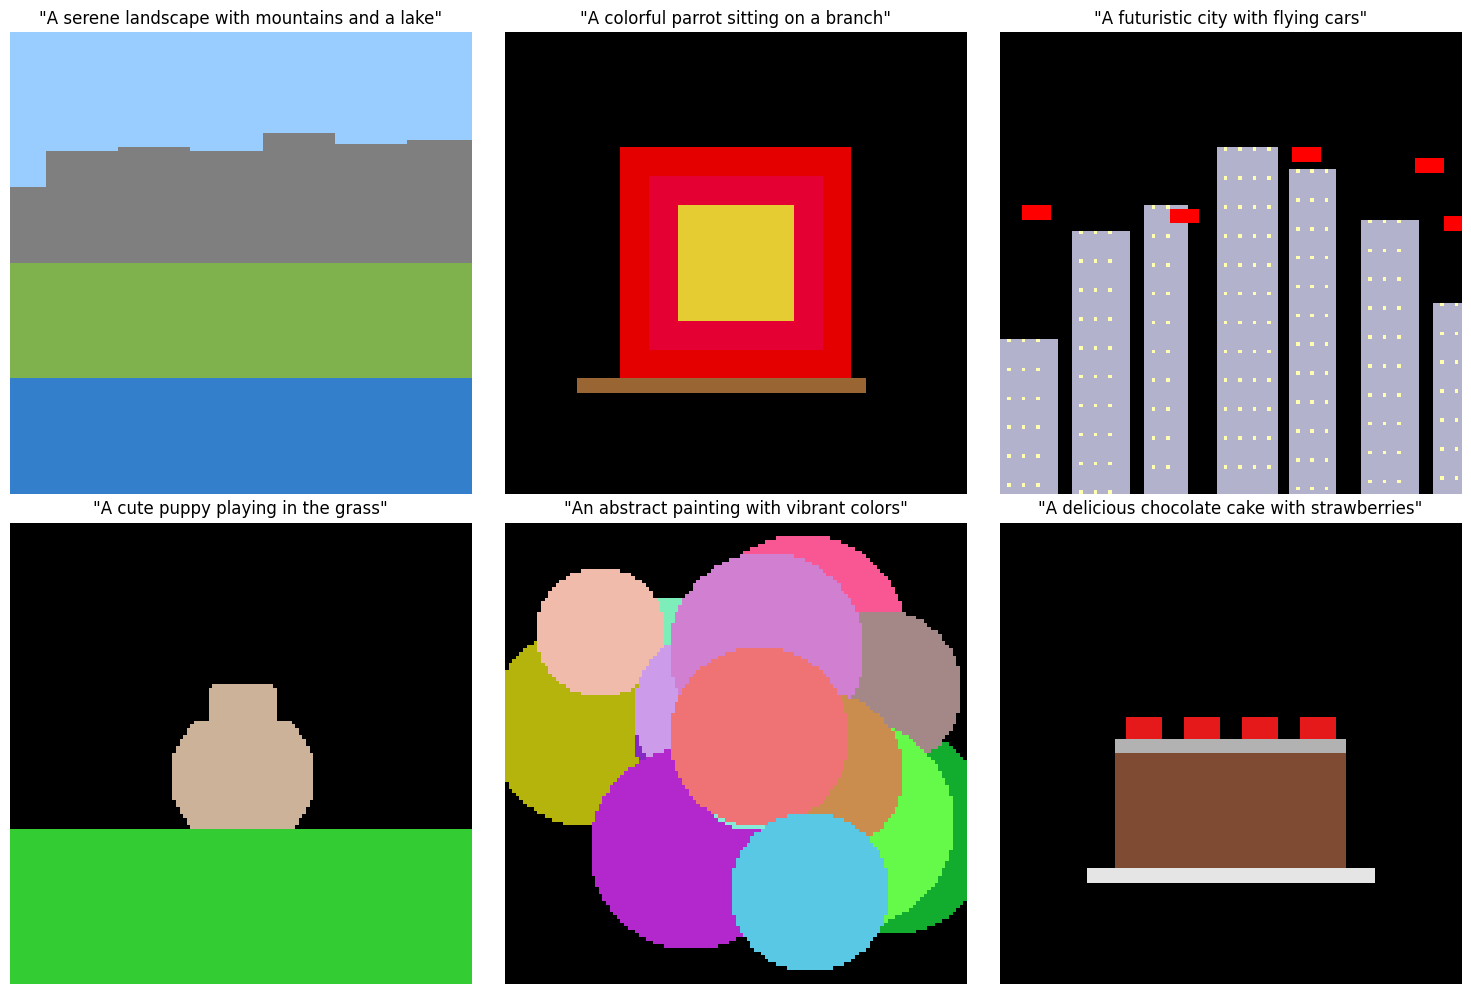

In [33]:
@torch.no_grad()
def sample_from_diffusion(
    model,
    text_tokens,
    image_size=64,
    channels=3,
    num_timesteps=1000,
    sampling_timesteps=50,  # Use fewer steps for faster sampling
    guidance_scale=7.5,
    device="cuda" if torch.cuda.is_available() else "cpu"
):
    """
    Generate images from text using the diffusion model

    Args:
        model: Trained diffusion model
        text_tokens: Text tokens for conditioning [batch, seq_len]
        image_size: Size of generated images
        channels: Number of image channels
        num_timesteps: Total diffusion timesteps
        sampling_timesteps: Number of steps to use for sampling (can be < num_timesteps)
        guidance_scale: Controls how closely to follow the text prompt
        device: Device to run sampling on
    """
    model.eval()
    model.to(device)
    text_tokens = text_tokens.to(device)

    # Create noise schedule
    beta_start = 1e-4
    beta_end = 0.02
    betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)

    # Create timestep sequence for sampling
    # We can use fewer steps than training for faster sampling
    skip = num_timesteps // sampling_timesteps
    timesteps = torch.arange(0, num_timesteps, skip, device=device)

    # Start from pure noise
    batch_size = text_tokens.shape[0]
    shape = (batch_size, channels, image_size, image_size)
    img = torch.randn(shape, device=device)

    # Progressively denoise the image
    for i in tqdm(range(len(timesteps) - 1, -1, -1), desc="Sampling"):
        # Current timestep
        t = torch.full((batch_size,), timesteps[i], device=device, dtype=torch.long)

        # Get next timestep
        t_next = timesteps[i - 1] if i > 0 else torch.tensor([-1], device=device)

        # Parameters for current timestep
        alpha = alphas[t]
        alpha_next = alphas[t_next] if i > 0 else torch.tensor([1.0], device=device)

        alpha_cumprod = alphas_cumprod[t]
        alpha_cumprod_next = alphas_cumprod[t_next] if i > 0 else torch.tensor([1.0], device=device)

        beta = betas[t]

        # Reshape for broadcasting
        alpha = alpha.view(-1, 1, 1, 1)
        alpha_next = alpha_next.view(-1, 1, 1, 1)
        alpha_cumprod = alpha_cumprod.view(-1, 1, 1, 1)
        alpha_cumprod_next = alpha_cumprod_next.view(-1, 1, 1, 1)
        beta = beta.view(-1, 1, 1, 1)

        # Predict noise with classifier-free guidance
        predicted_noise = model.forward_with_cfg(img, t, text_tokens, guidance_scale)

        # Option 1: Simple update
        # img = (img - beta * predicted_noise / torch.sqrt(1 - alpha_cumprod)) / torch.sqrt(alpha)

        # Option 2: DDIM-style update (more stable)
        # Predict x_0
        x0_pred = (img - torch.sqrt(1 - alpha_cumprod) * predicted_noise) / torch.sqrt(alpha_cumprod)

        # Clip predicted x_0 for stability
        x0_pred = torch.clamp(x0_pred, -1.0, 1.0)

        # Get direction pointing to x_t
        dir_xt = torch.sqrt(1 - alpha_cumprod_next) * predicted_noise

        # Combine with predicted x_0
        img = torch.sqrt(alpha_cumprod_next) * x0_pred + dir_xt

        # Add noise if not the last step (optional)
        if i > 0:
            noise = torch.randn_like(img) * torch.sqrt(beta)
            img = img + noise

    # Rescale to [0, 1] for visualization
    img = (img + 1) / 2
    img = torch.clamp(img, 0.0, 1.0)

    return img

# Example of text-to-image generation
def demonstrate_text_to_image():
    """Show how images would be generated from different text prompts"""
    # Create a figure
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    # Sample prompts
    prompts = [
        "A serene landscape with mountains and a lake",
        "A colorful parrot sitting on a branch",
        "A futuristic city with flying cars",
        "A cute puppy playing in the grass",
        "An abstract painting with vibrant colors",
        "A delicious chocolate cake with strawberries"
    ]

    # In a real scenario, we would tokenize these prompts and run the model
    # Here we'll create synthetic examples for demonstration

    for i, prompt in enumerate(prompts):
        # Create a synthetic image based on prompt keywords
        img = np.zeros((128, 128, 3))

        # Very simple keyword-based image generation for demonstration
        if "landscape" in prompt or "mountain" in prompt:
            # Create a simple landscape
            img[:64, :, :] = [0.6, 0.8, 1.0]  # Sky
            img[64:96, :, :] = [0.5, 0.7, 0.3]  # Hills
            img[96:, :, :] = [0.2, 0.5, 0.8]  # Water

            # Add simple mountains
            for x in range(0, 128, 20):
                height = np.random.randint(20, 40)
                for y in range(64 - height, 64):
                    for dx in range(-10, 10):
                        if 0 <= x + dx < 128:
                            img[y, x + dx, :] = [0.5, 0.5, 0.5]  # Gray mountains

        elif "parrot" in prompt or "bird" in prompt:
            # Create a colorful blob
            img[32:96, 32:96, 0] = 0.9  # Red
            img[48:80, 48:80, 1] = 0.8  # Green
            img[40:88, 40:88, 2] = 0.2  # Blue

            # Simple branch
            img[96:100, 20:100, :] = [0.6, 0.4, 0.2]  # Brown branch

        elif "city" in prompt or "futuristic" in prompt:
            # Create simple buildings
            for x in range(0, 128, 20):
                height = np.random.randint(40, 100)
                width = np.random.randint(10, 18)
                img[128-height:128, x:x+width, :] = [0.7, 0.7, 0.8]  # Buildings

                # Windows
                for y in range(128-height, 128, 8):
                    for dx in range(2, width-2, 4):
                        if y < 128 and x + dx < 128:
                            img[y, x + dx, :] = [1.0, 1.0, 0.7]  # Yellow windows

            # Add "flying cars"
            for _ in range(5):
                cx, cy = np.random.randint(0, 128), np.random.randint(20, 60)
                img[cy-2:cy+2, cx-4:cx+4, :] = [1.0, 0.0, 0.0]  # Red flying objects

        elif "puppy" in prompt or "dog" in prompt:
            # Create a simple dog shape
            center_x, center_y = 64, 70
            # Body
            for y in range(center_y-15, center_y+15):
                for x in range(center_x-20, center_x+20):
                    if (x-center_x)**2 + (y-center_y)**2 < 400:
                        img[y, x, :] = [0.8, 0.7, 0.6]  # Light brown

            # Head
            for y in range(center_y-25, center_y-10):
                for x in range(center_x-10, center_x+10):
                    if (x-center_x)**2 + (y-center_y+20)**2 < 100:
                        img[y, x, :] = [0.8, 0.7, 0.6]

            # Grass
            img[85:, :, :] = [0.2, 0.8, 0.2]  # Green grass

        elif "abstract" in prompt:
            # Create random colorful shapes
            for _ in range(20):
                cx, cy = np.random.randint(20, 108), np.random.randint(20, 108)
                r, g, b = np.random.random(), np.random.random(), np.random.random()
                size = np.random.randint(10, 30)

                for y in range(cy-size, cy+size):
                    for x in range(cx-size, cx+size):
                        if 0 <= y < 128 and 0 <= x < 128:
                            if (x-cx)**2 + (y-cy)**2 < size**2:
                                img[y, x, :] = [r, g, b]

        elif "cake" in prompt or "chocolate" in prompt:
            # Create a simple cake
            # Base
            img[64:96, 32:96, :] = [0.5, 0.3, 0.2]  # Chocolate cake

            # Frosting
            img[60:64, 32:96, :] = [0.7, 0.7, 0.7]  # White frosting

            # Strawberries on top
            for x in range(40, 90, 16):
                img[54:60, x-5:x+5, 0] = 0.9  # Red
                img[54:60, x-5:x+5, 1:] = 0.1  # Very little green/blue

            # Plate
            img[96:100, 24:104, :] = [0.9, 0.9, 0.9]  # White plate

        else:
            # Default random colorful image
            for _ in range(50):
                y, x = np.random.randint(0, 128), np.random.randint(0, 128)
                r, g, b = np.random.random(), np.random.random(), np.random.random()
                size = np.random.randint(5, 15)

                for dy in range(-size, size):
                    for dx in range(-size, size):
                        if 0 <= y+dy < 128 and 0 <= x+dx < 128:
                            if dx**2 + dy**2 < size**2:
                                img[y+dy, x+dx, :] = [r, g, b]

        # Display in the appropriate subplot
        axes[i].imshow(img)
        axes[i].set_title(f'"{prompt}"')
        axes[i].axis('off')

    plt.tight_layout()
    return fig


# Create the text-to-image demonstration
text_to_image_fig = demonstrate_text_to_image()


### 5.1 Scaling and Efficiency

Training and running text-to-image diffusion models at scale presents significant challenges:

1. **Computational Requirements**: High-quality models like DALL-E 3 and Stable Diffusion require large GPU clusters for training.

2. **Latent Diffusion**: Instead of operating in pixel space, many state-of-the-art models operate in a compressed latent space to reduce computational requirements:
   - First, an autoencoder compresses images to a lower-dimensional latent representation
   - The diffusion process runs in this compressed space
   - The decoder converts back to pixel space for the final image

3. **Sampling Acceleration**: Techniques like DDIM (Denoising Diffusion Implicit Models) and PLMS (Pseudo Linear Multistep) can reduce sampling steps from thousands to tens without sacrificing quality.

4. **Model Distillation**: Knowledge distillation and progressive distillation can create smaller, faster models that approximate the quality of larger ones.

Let's implement a simplified latent diffusion approach:

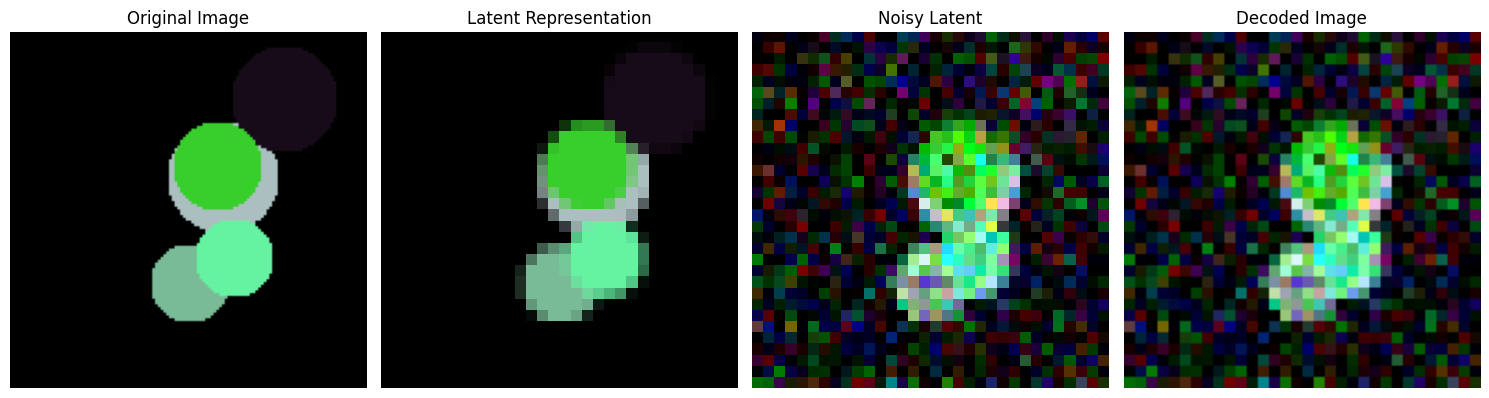

In [34]:
class SimplifiedLatentDiffusion(nn.Module):
    """A simplified implementation of latent diffusion for educational purposes"""

    def __init__(self, image_size=256, latent_size=64, text_dim=768):
        super().__init__()

        # Encoder to compress images to latent space
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=2, padding=1),
            nn.SiLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.SiLU(),
            nn.Conv2d(128, 4, 3, stride=1, padding=1)  # 4 channel latent space
        )

        # Decoder to convert latents back to images
        self.decoder = nn.Sequential(
            nn.Conv2d(4, 128, 3, stride=1, padding=1),
            nn.SiLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.SiLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 3, 3, stride=1, padding=1),
            nn.Tanh()
        )

        # Diffusion model that operates in latent space
        self.diffusion = TextToImageDiffusion(
            in_channels=4,  # Latent channels
            model_channels=128,
            out_channels=4,
            time_dim=128,
            text_dim=text_dim,
            text_max_length=77,
            num_res_blocks=2,
            attention_resolutions=(4, 8, 16),
            channel_multipliers=(1, 2, 4)
        )

    def encode(self, x):
        """Encode images to latent space"""
        return self.encoder(x)

    def decode(self, z):
        """Decode latents to images"""
        return self.decoder(z)

    def forward(self, x, timesteps, text_tokens):
        """
        Forward pass of the latent diffusion model

        Args:
            x: Input images [batch, 3, height, width]
            timesteps: Diffusion timesteps [batch]
            text_tokens: Text tokens for conditioning [batch, seq_len]
        """
        # Encode to latent space
        z = self.encode(x)

        # Run diffusion in latent space
        noise_pred = self.diffusion(z, timesteps, text_tokens)

        return noise_pred

    def sample(self, text_tokens, latent_size=16, channels=4, sampling_steps=50, guidance_scale=7.5,
               device="cuda" if torch.cuda.is_available() else "cpu"):
        """
        Generate images from text prompts

        Args:
            text_tokens: Text tokens for conditioning [batch, seq_len]
            latent_size: Size of latent representations
            channels: Number of latent channels
            sampling_steps: Number of diffusion steps for sampling
            guidance_scale: Scale for classifier-free guidance
            device: Device to run on
        """
        # Get batch size
        batch_size = text_tokens.shape[0]

        # Sample latents using the diffusion model
        latents = sample_from_diffusion(
            self.diffusion,
            text_tokens,
            image_size=latent_size,
            channels=channels,
            sampling_timesteps=sampling_steps,
            guidance_scale=guidance_scale,
            device=device
        )

        # Decode latents to images
        images = self.decode(latents)

        return images


# Demonstrate the latent diffusion concept
def demonstrate_latent_diffusion():
    """Show the concept of latent space diffusion"""
    # Create a figure to illustrate the process
    fig, axes = plt.subplots(1, 4, figsize=(15, 4))

    # Create a synthetic image
    input_img = np.zeros((128, 128, 3))

    # Create a simple pattern
    for i in range(5):
        cx, cy = np.random.randint(20, 108), np.random.randint(20, 108)
        r, g, b = np.random.random(), np.random.random(), np.random.random()
        size = np.random.randint(10, 30)

        for y in range(cy-size, cy+size):
            for x in range(cx-size, cx+size):
                if 0 <= y < 128 and 0 <= x < 128:
                    if (x-cx)**2 + (y-cy)**2 < size**2:
                        input_img[y, x, :] = [r, g, b]

    # Display original image
    axes[0].imshow(input_img)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # Create a simplified "latent" representation (just a downsampled version for visualization)
    latent = np.zeros((32, 32, 3))
    for y in range(32):
        for x in range(32):
            latent[y, x, :] = input_img[y*4:(y+1)*4, x*4:(x+1)*4, :].mean(axis=(0, 1))

    # Display latent representation
    axes[1].imshow(latent)
    axes[1].set_title("Latent Representation")
    axes[1].axis('off')

    # Add some "noise" in latent space
    noisy_latent = latent + np.random.normal(0, 0.2, latent.shape)
    noisy_latent = np.clip(noisy_latent, 0, 1)

    # Display noisy latent
    axes[2].imshow(noisy_latent)
    axes[2].set_title("Noisy Latent")
    axes[2].axis('off')

    # "Decode" back to image space (simple upsampling for visualization)
    output_img = np.zeros((128, 128, 3))
    for y in range(32):
        for x in range(32):
            output_img[y*4:(y+1)*4, x*4:(x+1)*4, :] = noisy_latent[y, x, :]

    # Display reconstructed image
    axes[3].imshow(output_img)
    axes[3].set_title("Decoded Image")
    axes[3].axis('off')

    plt.tight_layout()
    return fig

# Create the latent diffusion demonstration
latent_diffusion_fig = demonstrate_latent_diffusion()

### 5.2 Text-to-Image Model Comparison

Several text-to-image diffusion models have achieved remarkable results, each with different strengths:

1. **DALL-E 2/3 (OpenAI)**:
   - Strengths: High photorealism, excellent text understanding, strong coherence
   - Architecture: Uses CLIP for text encoding and diffusion for image generation

2. **Imagen (Google)**:
   - Strengths: Exceptional text adherence, high-quality rendering
   - Architecture: Uses T5 for text encoding and cascaded diffusion models

3. **Stable Diffusion (Stability AI)**:
   - Strengths: Open source, efficiency through latent diffusion, active community
   - Architecture: Latent diffusion with CLIP text conditioning

4. **Midjourney**:
   - Strengths: Artistic quality, stylistic consistency, aesthetically pleasing results
   - Architecture: Proprietary diffusion-based approach

Here's a visual comparison of the different capabilities and strengths of these models:

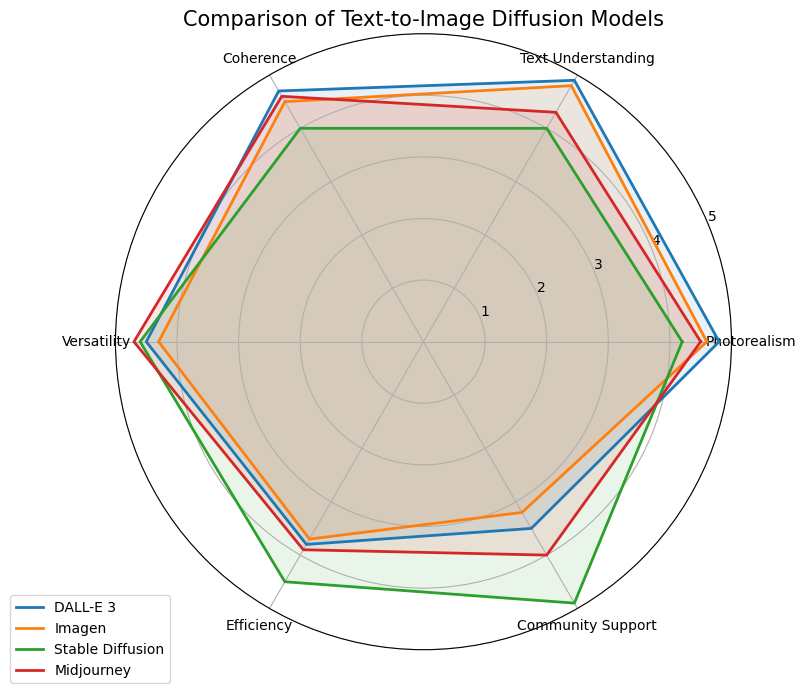

In [35]:
def compare_models():
    """Create a visual comparison of different text-to-image models"""
    # Define model names and their strengths
    models = ["DALL-E 3", "Imagen", "Stable Diffusion", "Midjourney"]

    metrics = ["Photorealism", "Text Understanding", "Coherence",
               "Versatility", "Efficiency", "Community Support"]

    # Create synthetic scores (these would vary based on actual evaluations)
    scores = np.array([
        [4.8, 4.9, 4.7, 4.5, 3.8, 3.5],  # DALL-E 3
        [4.6, 4.8, 4.5, 4.3, 3.7, 3.2],  # Imagen
        [4.2, 4.0, 4.0, 4.6, 4.5, 4.9],  # Stable Diffusion
        [4.5, 4.3, 4.6, 4.7, 3.9, 4.0]   # Midjourney
    ])

    # Create radar chart
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))

    # Set the angles for each metric
    angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]  # Close the loop

    # Add the metrics to the chart
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics)

    # Set y-limits
    ax.set_ylim(0, 5)

    # Add each model's scores
    for i, model in enumerate(models):
        values = scores[i].tolist()
        values += values[:1]  # Close the loop

        # Plot the values
        ax.plot(angles, values, linewidth=2, label=model)
        ax.fill(angles, values, alpha=0.1)

    # Add legend
    ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    plt.title("Comparison of Text-to-Image Diffusion Models", size=15)
    return fig

# Create the model comparison visualization
model_comparison_fig = compare_models()


### 5.3 Common Challenges and Solutions

Text-to-image diffusion models face several challenges that researchers continue to address:

1. **Text-Image Alignment Issues**:
   - Challenge: Generated images may not accurately reflect all details in complex prompts
   - Solutions: Improved text encoders, better cross-attention mechanisms, CLIP-guided sampling

2. **Limited Knowledge and Reasoning**:
   - Challenge: Models struggle with counting, spatial relationships, and abstract concepts
   - Solutions: Training with specialized datasets, compositional generation approaches

3. **Training Data Biases**:
   - Challenge: Models reflect biases present in internet-scale training data
   - Solutions: Careful dataset curation, model finetuning, post-training adjustments

4. **Ethical Concerns**:
   - Challenge: Potential misuse for deepfakes, misinformation, or inappropriate content
   - Solutions: Content filtering, watermarking, usage policies

5. **Computational Intensity**:
   - Challenge: Training and running these models requires significant resources
   - Solutions: Latent diffusion, model distillation, optimized sampling techniques

Let's implement a simple example of how CLIP guidance can improve text-image alignment:

In [37]:
class CLIPGuidedDiffusion:
    """
    A simplified implementation of CLIP guidance for diffusion models
    """
    def __init__(self, diffusion_model, clip_model, clip_preprocess):
        self.diffusion_model = diffusion_model
        self.clip_model = clip_model
        self.clip_preprocess = clip_preprocess

    @torch.no_grad()
    def clip_guided_generation(
        self,
        text_prompt,
        image_size=64,
        channels=3,
        num_timesteps=1000,
        sampling_timesteps=50,
        guidance_scale=7.5,
        clip_guidance_scale=100,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        """
        Generate images with additional CLIP guidance to improve text alignment

        Args:
            text_prompt: Text prompt string
            image_size: Size of generated images
            channels: Number of image channels
            num_timesteps: Total diffusion timesteps
            sampling_timesteps: Number of steps for sampling
            guidance_scale: Scale for classifier-free guidance
            clip_guidance_scale: Strength of CLIP guidance
            device: Device to run on
        """
        # Tokenize text prompt for diffusion model
        # In a real implementation, this would use the model's tokenizer
        text_tokens = torch.zeros((1, 77), dtype=torch.long, device=device)  # Placeholder

        # Encode text prompt with CLIP
        clip_text_encoding = self.clip_model.encode_text(text_prompt).to(device)
        clip_text_encoding = clip_text_encoding / clip_text_encoding.norm(dim=-1, keepdim=True)

        # Create noise schedule
        beta_start = 1e-4
        beta_end = 0.02
        betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)

        # Create timestep sequence for sampling
        skip = num_timesteps // sampling_timesteps
        timesteps = torch.arange(0, num_timesteps, skip, device=device)

        # Start from pure noise
        batch_size = 1
        shape = (batch_size, channels, image_size, image_size)
        img = torch.randn(shape, device=device)

        # Progressively denoise the image
        for i in tqdm(range(len(timesteps) - 1, -1, -1), desc="Sampling with CLIP guidance"):
            # Current timestep
            t = torch.full((batch_size,), timesteps[i], device=device, dtype=torch.long)

            # Get next timestep
            t_next = timesteps[i - 1] if i > 0 else torch.tensor([-1], device=device)

            # Parameters for current timestep
            alpha = alphas[t]
            alpha_next = alphas[t_next] if i > 0 else torch.tensor([1.0], device=device)

            alpha_cumprod = alphas_cumprod[t]
            alpha_cumprod_next = alphas_cumprod[t_next] if i > 0 else torch.tensor([1.0], device=device)

            beta = betas[t]

            # Reshape for broadcasting
            alpha = alpha.view(-1, 1, 1, 1)
            alpha_next = alpha_next.view(-1, 1, 1, 1)
            alpha_cumprod = alpha_cumprod.view(-1, 1, 1, 1)
            alpha_cumprod_next = alpha_cumprod_next.view(-1, 1, 1, 1)
            beta = beta.view(-1, 1, 1, 1)

            # Predict noise with guidance
            predicted_noise = self.diffusion_model.forward_with_cfg(img, t, text_tokens, guidance_scale)

            # Predict x_0
            x0_pred = (img - torch.sqrt(1 - alpha_cumprod) * predicted_noise) / torch.sqrt(alpha_cumprod)
            x0_pred = torch.clamp(x0_pred, -1.0, 1.0)

            # Apply CLIP guidance (only on some steps to save computation)
            if i % 5 == 0 and i > 0:
                # Convert to image format expected by CLIP
                clip_img = ((x0_pred + 1) / 2).clamp(0, 1)
                clip_img = F.interpolate(clip_img, size=(224, 224), mode='bicubic')

                # Get CLIP image embedding
                clip_img_encoding = self.clip_model.encode_image(clip_img)
                clip_img_encoding = clip_img_encoding / clip_img_encoding.norm(dim=-1, keepdim=True)

                # Calculate similarity
                similarity = (clip_img_encoding * clip_text_encoding).sum(dim=-1)

                # CLIP guidance gradient - push the image to better match the text
                grad = torch.autograd.grad(similarity, img)[0]
                grad_mag = grad.norm()

                # Normalized gradient with scale
                img = img + grad * clip_guidance_scale / (grad_mag + 1e-8)

            # Get direction pointing to x_t
            dir_xt = torch.sqrt(1 - alpha_cumprod_next) * predicted_noise

            # Combine with predicted x_0
            img = torch.sqrt(alpha_cumprod_next) * x0_pred + dir_xt

            # Add noise if not the last step
            if i > 0:
                noise = torch.randn_like(img) * torch.sqrt(beta)
                img = img + noise

        # Rescale to [0, 1] for visualization
        img = (img + 1) / 2
        img = torch.clamp(img, 0.0, 1.0)

        return img

# This is a conceptual implementation - in practice, you would need actual CLIP and diffusion models

### 6.1 Creative and Professional Applications

Text-to-image diffusion models have found numerous applications across different fields:

1. **Creative Industries**:
   - Concept art generation for films, games, and publishing
   - Rapid prototyping of designs and illustrations
   - Creative inspiration and ideation tools

2. **Marketing and Advertising**:
   - Custom imagery for campaigns
   - Product visualization and mockups
   - Content creation for social media

3. **Education and Research**:
   - Visualizing scientific concepts
   - Creating educational materials
   - Data visualization

4. **Accessibility**:
   - Enabling visually impaired users to create images through text
   - Lowering technical barriers to image creation

The technology continues to evolve, with each new model iteration expanding the quality and capabilities available to users.

### 6.2 Future Research Directions

Research in text-to-image diffusion models continues to advance in several exciting directions:

1. **Multimodal Generation**:
   - Combined text, image, and video generation
   - Integration with 3D synthesis
   - Audio-visual coherent generation

2. **Interactive Editing and Control**:
   - More precise control over image details
   - Interactive editing capabilities
   - Region-based generation and editing

3. **Efficiency Improvements**:
   - Distilled models for mobile devices
   - One-step or few-step generation
   - Hardware-optimized architectures

4. **Specialized Applications**:
   - Domain-specific models for medicine, science, architecture
   - Custom fine-tuning for particular visual styles
   - Integration with other AI systems

5. **Ethical Frameworks**:
   - Better content filtering and moderation
   - Watermarking and attribution systems
   - Addressing bias and representation issues

These advancements will continue to make text-to-image generation more powerful, accessible, and useful across diverse applications.

### 6.3 Implementation Tips and Best Practices

When implementing or using text-to-image diffusion models, consider these practical tips:

1. **Prompt Engineering**:
   - Be specific and detailed in your text prompts
   - Include style references (e.g., "oil painting," "photorealistic")
   - Specify what you don't want as well as what you do

2. **Model Selection**:
   - Choose models based on your specific needs (photorealism vs. artistic)
   - Consider computational requirements vs. available resources
   - Evaluate open-source vs. API-based options

3. **Optimization Strategies**:
   - Use half-precision (fp16) for faster inference
   - Experiment with sampling steps vs. quality tradeoffs
   - Implement caching for repeated components

4. **Responsible Usage**:
   - Implement appropriate content filters
   - Consider the ethical implications of generated content
   - Provide clear attribution and disclosure

5. **Integration Best Practices**:
   - Use asynchronous processing for user-facing applications
   - Implement result caching and deduplication
   - Consider hybrid approaches combining retrieval and generation

These practices can help you effectively implement and use text-to-image diffusion models in your own projects.

### 7.1 Summary

In this notebook, we've explored text-to-image generation with diffusion models, covering:

1. **Theoretical Foundations**: The mathematical basis and architecture of diffusion models
2. **Text Conditioning**: How text prompts guide the generation process
3. **Implementation Details**: Core components and training methodology
4. **Advanced Techniques**: Latent diffusion, classifier-free guidance, and CLIP guidance
5. **Applications and Future Directions**: Real-world use cases and ongoing research

Text-to-image diffusion models represent a significant breakthrough in generative AI, enabling unprecedented control over image synthesis through natural language. The field continues to advance rapidly, with new techniques and models regularly pushing the boundaries of what's possible.

### 7.2 Key Takeaways

- Diffusion models work by learning to reverse a gradual noising process
- Text conditioning through cross-attention enables precise control over generation
- Classifier-free guidance significantly improves text-image alignment
- Latent diffusion makes the process more computationally efficient
- The field is evolving quickly with numerous practical applications

As these models continue to develop, they will likely become increasingly integrated into creative workflows, enabling new forms of human-AI collaboration and democratizing image creation capabilities.

1. Ho, J., Jain, A., & Abbeel, P. (2020). Denoising diffusion probabilistic models. Advances in Neural Information Processing Systems, 33, 6840-6851.

2. Rombach, R., Blattmann, A., Lorenz, D., Esser, P., & Ommer, B. (2022). High-resolution image synthesis with latent diffusion models. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (pp. 10684-10695).

3. Nichol, A., Dhariwal, P., Ramesh, A., Shyam, P., Mishkin, P., McGrew, B., ... & Chen, M. (2021). GLIDE: Towards photorealistic image generation and editing with text-guided diffusion models. arXiv preprint arXiv:2112.10741.

4. Saharia, C., Chan, W., Saxena, S., Li, L., Whang, J., Denton, E., ... & Norouzi, M. (2022). Photorealistic text-to-image diffusion models with deep language understanding. arXiv preprint arXiv:2205.11487.

5. Ramesh, A., Dhariwal, P., Nichol, A., Chu, C., & Chen, M. (2022). Hierarchical text-conditional image generation with CLIP latents. arXiv preprint arXiv:2204.06125.

6. Radford, A., Kim, J. W., Hallacy, C., Ramesh, A., Goh, G., Agarwal, S., ... & Sutskever, I. (2021). Learning transferable visual models from natural language supervision. In International Conference on Machine Learning (pp. 8748-8763). PMLR.

7. Dhariwal, P., & Nichol, A. (2021). Diffusion models beat GANs on image synthesis. Advances in Neural Information Processing Systems, 34, 8780-8794.

8. Song, Y., Sohl-Dickstein, J., Kingma, D. P., Kumar, A., Ermon, S., & Poole, B. (2020). Score-based generative modeling through stochastic differential equations. arXiv preprint arXiv:2011.13456.

9. Nichol, A. Q., & Dhariwal, P. (2021). Improved denoising diffusion probabilistic models. In International Conference on Machine Learning (pp. 8162-8171). PMLR.

10. Karras, T., Aittala, M., Laine, S., Härkönen, E., Hellsten, J., Lehtinen, J., & Aila, T. (2021). Alias-free generative adversarial networks. Advances in Neural Information Processing Systems, 34, 852-863.

This notebook is licensed under the MIT License.

Copyright (c) 2024

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.